In [5]:
import backtrader as bt
import pandas as pd
import duckdb

etfs = ['561300', '159726', '515100', '513500', '161119',
        '518880', '164824', '159985', '513330', '513100',
        '513030', '513520']
start_date = '2025-08-18'
end_date   = '2025-08-18'

con = duckdb.connect(database=':memory:', read_only=False) 
symbols_tuple = tuple(etfs)

path = '../dataset/data/etf_prices/**/data.parquet'

query = f"""
SELECT
    date,
    open,
    high,
    low,
    close,
    volume,
    turnover,
    symbol
FROM read_parquet('{path}')
WHERE symbol IN {symbols_tuple}
AND date BETWEEN '{start_date}' AND '{end_date}'
ORDER BY symbol, date
"""

df_all = con.execute(query).df()
con.close()

# 类型转换
df_all['date'] = pd.to_datetime(df_all['date'])
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
df_all[numeric_cols] = df_all[numeric_cols].astype(float)
df_all.tail(10)

,date,open,high,low,close,volume,turnover,symbol
2,2025-08-18,1.755,1.756,1.749,1.751,513676.0,9.003581e+07,161119
3,2025-08-18,1.477,1.493,1.477,1.490,927733.0,1.380202e+08,164824
4,2025-08-18,1.903,1.904,1.894,1.895,742017.0,1.409633e+08,513030
5,2025-08-18,8.575,8.590,8.540,8.550,4454914.0,7.637596e+08,513100
6,2025-08-18,0.532,0.540,0.531,0.536,64046123.0,3.432634e+09,513330
7,2025-08-18,4.418,4.422,4.402,4.406,1457107.0,3.214695e+08,513500
8,2025-08-18,1.639,1.649,1.638,1.642,742906.0,1.221130e+08,513520
9,2025-08-18,1.977,1.985,1.974,1.980,502174.0,7.748985e+07,515100
10,2025-08-18,7.398,7.430,7.393,7.413,2281711.0,1.690072e+09,518880
11,2025-08-18,0.904,0.915,0.902,0.909,594706.0,5.408680e+07,561300


In [31]:
# ------------------------------------------------------------------
# 2. 构造 cerebro 并循环添加每个 ETF 的数据
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

for symbol in etfs:
    # 取出当前标的
    df_sym = df_all[df_all['symbol'] == symbol].copy()

    # 确保按日期排序
    df_sym.sort_values('date', inplace=True)

    # 设置 datetime 为索引
    df_sym.set_index('date', inplace=True)

    # 删除多余的 symbol 列
    df_sym.drop(columns=['symbol'], inplace=True)

    # 缺失值前向填充（如有停牌）
    df_sym = df_sym.ffill()

    # 构建 backtrader 数据源
    data = bt.feeds.PandasData(
        dataname=df_sym,
        name=symbol,
        # 如果列名与默认一致，无需额外映射
    )
    cerebro.adddata(data)
# ------------------------------------------------------------------
# 3. 示例策略：每天收盘后打印所有标的价格
# ------------------------------------------------------------------
class MomentumTopN(bt.Strategy):
    params = (
        ('momentum_period', 13),   # 动量周期
        ('ma_period', 120),        # 均线周期
        ('topn', 3),               # 每期最大持仓数
        ('rebalance_days', 5),     # 调仓间隔
    )

    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = dict(
                momentum=bt.indicators.ROC(d.close,
                                           period=self.p.momentum_period),
                ma=bt.indicators.SimpleMovingAverage(d.close,
                                                     period=self.p.ma_period)
            )
        self.counter = 0

    def next(self):
        self.counter += 1
        if self.counter % self.p.rebalance_days != 0:
            return  # 不到调仓日
        # 1. 过滤：收盘价必须站在 120 日均线上方
        eligible = []
        for d in self.datas:
            if len(d) >= max(self.p.momentum_period, self.p.ma_period):
                if d.close[0] > self.inds[d]['ma'][0]:
                    eligible.append(d)

        # 2. 按 20 日动量排序（从高到低）
        eligible.sort(key=lambda d: self.inds[d]['momentum'][0], reverse=True)

        # 3. 选出 TopN
        top = eligible[:self.p.topn]

        # 4. 计算等权权重
        weight = 1.0 / len(top) if top else 0.0

        # 5. 调仓：清仓不在 top 的，买入新的
        for d in self.datas:
            pos = self.getposition(d).size
            if d in top:
                target_size = int((weight * self.broker.getvalue()) / d.close[0])
                if pos != target_size:
                    self.order_target_size(d, target_size)
            else:
                if pos:
                    self.order_target_size(d, 0)

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

cerebro.addstrategy(MomentumTopN)
cerebro.broker.setcommission(commission=0.0005)
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.broker.setcash(100000) 

# ------------------------------------------------------------------
# 4. 运行回测
# ------------------------------------------------------------------
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/utils.py:314: UserWarning: Detected intraday strategy; inferring positionsfrom transactions. Set estimate_intraday=False to disable.
  warnings.warn(
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/utils.py:376: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition = txn_val["exposure"] == txn_val.groupby(pd.Grouper(freq="24H"))[
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/utils.py:378: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ].transform(max)
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/utils.py:386: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as la

Start date,2022-07-01
End date,2025-07-31
Total months,35
,Backtest
Annual return,7.69%
Cumulative returns,24.633%
Annual volatility,12.544%
Sharpe ratio,0.65
Calmar ratio,0.54
Stability,0.85
Max drawdown,-14.367%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.37,2025-03-19,2025-04-07,NaT,NaN
1,11.06,2024-07-15,2024-08-05,2025-01-21,137
2,9.02,2023-07-31,2023-10-25,2024-03-29,175
3,4.23,2023-02-16,2023-04-25,2023-05-30,74
4,3.61,2025-01-24,2025-01-27,2025-02-14,16


/home/jovyan/data/.venv/lib/python3.11/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.03%,-9.03%,3.65%


Top 10 long positions of all time,max
sid,
513330,25054.26%
161119,14214.98%
159726,4726.52%
518880,3149.51%
164824,2760.91%
515100,1103.34%
159985,109.71%
513500,104.37%
513100,102.80%


Top 10 short positions of all time,max
sid,
513500,-24900.22%
164824,-24134.70%
518880,-19074.34%
161119,-17866.78%
561300,-14182.04%
513100,-9372.93%
159726,-3875.75%
515100,-3231.21%
513030,-1797.93%


Top 10 positions of all time,max
sid,
513330,25054.26%
513500,24900.22%
164824,24134.70%
518880,19074.34%
161119,17866.78%
561300,14182.04%
513100,9372.93%
159726,4726.52%
515100,3231.21%


/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()
/home/jovyan/data/.venv/lib/python3.11/site-packages/pyfolio/round_trips.py:139: FutureWarning: DataFrameGr

Summary stats,All trades,Long trades
Total number of round_trips,134.00,134.00
Percent profitable,0.66,0.66
Winning round_trips,88.00,88.00
Losing round_trips,42.00,42.00
Even round_trips,4.00,4.00


PnL stats,All trades,Long trades
Total profit,$24342.17,$24342.17
Gross profit,$58631.91,$58631.91
Gross loss,$-34289.74,$-34289.74
Profit factor,$1.71,$1.71
Avg. trade net profit,$181.66,$181.66
Avg. winning trade,$666.27,$666.27
Avg. losing trade,$-816.42,$-816.42
Ratio Avg. Win:Avg. Loss,$0.82,$0.82
Largest winning trade,$10291.18,$10291.18
Largest losing trade,$-5915.86,$-5915.86


Duration stats,All trades,Long trades
Avg duration,25 days 16:17:54.626865671,25 days 16:17:54.626865671
Median duration,14 days 00:00:00,14 days 00:00:00
Longest duration,298 days 00:00:00,298 days 00:00:00
Shortest duration,7 days 00:00:00,7 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,16.01%,16.01%
Avg returns winning,50.13%,50.13%
Avg returns losing,-53.94%,-53.94%
Median returns all round_trips,0.11%,0.11%
Median returns winning,0.69%,0.69%
Median returns losing,-1.55%,-1.55%
Largest winning trade,1721.98%,1721.98%
Largest losing trade,-809.43%,-809.43%


Symbol stats,159726,159985,161119,164824,513030,513100,513330,513500,515100,518880,561300
Avg returns all round_trips,-19.26%,6.69%,7.25%,34.69%,9.94%,90.80%,-19.81%,92.81%,9.47%,-46.01%,-108.10%
Avg returns winning,2.70%,6.69%,14.71%,46.96%,11.18%,160.20%,28.52%,117.92%,13.73%,33.05%,0.21%
Avg returns losing,-35.23%,NaN,-5.39%,-21.55%,-1.23%,-1.74%,-80.22%,-1.38%,-7.58%,-204.15%,-129.76%
Median returns all round_trips,-0.29%,0.71%,0.09%,0.13%,3.61%,0.10%,0.07%,0.58%,0.52%,0.07%,-2.85%
Median returns winning,0.16%,0.71%,0.27%,0.37%,4.01%,2.52%,3.33%,2.24%,1.80%,0.95%,0.21%
Median returns losing,-1.49%,NaN,-1.25%,-21.55%,-1.23%,-1.20%,-74.70%,-0.42%,-7.58%,-3.53%,-5.53%
Largest winning trade,20.40%,37.06%,103.54%,260.55%,54.02%,1108.22%,124.04%,1721.98%,99.19%,201.60%,0.21%
Largest losing trade,-198.51%,0.07%,-14.74%,-40.15%,-1.23%,-5.30%,-170.29%,-4.68%,-11.89%,-809.43%,-602.82%


Profitability (PnL / PnL total) per name,
symbol,
513030,62.30%
513500,42.72%
513100,20.28%
159985,10.75%
164824,6.76%
515100,4.74%
518880,3.09%
161119,2.52%
513330,-11.03%


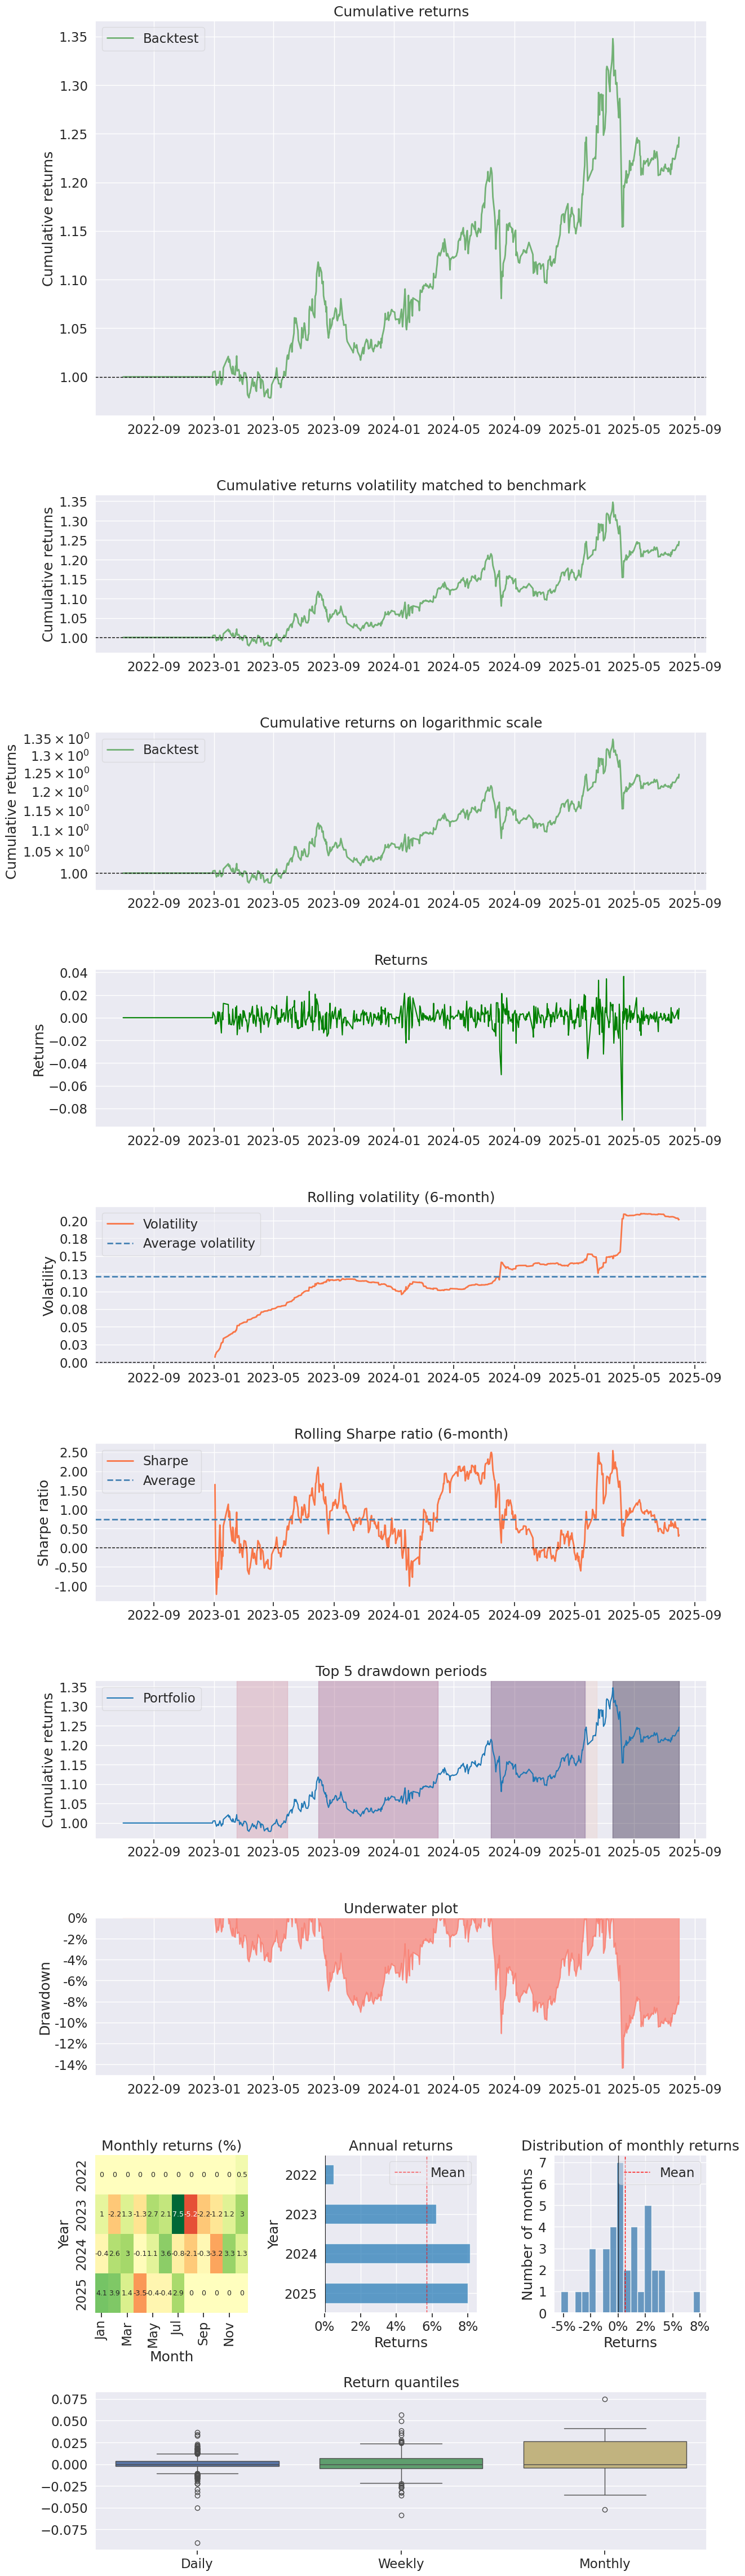

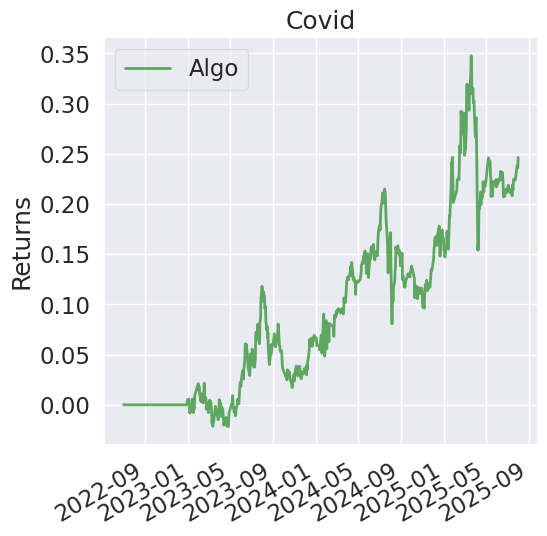

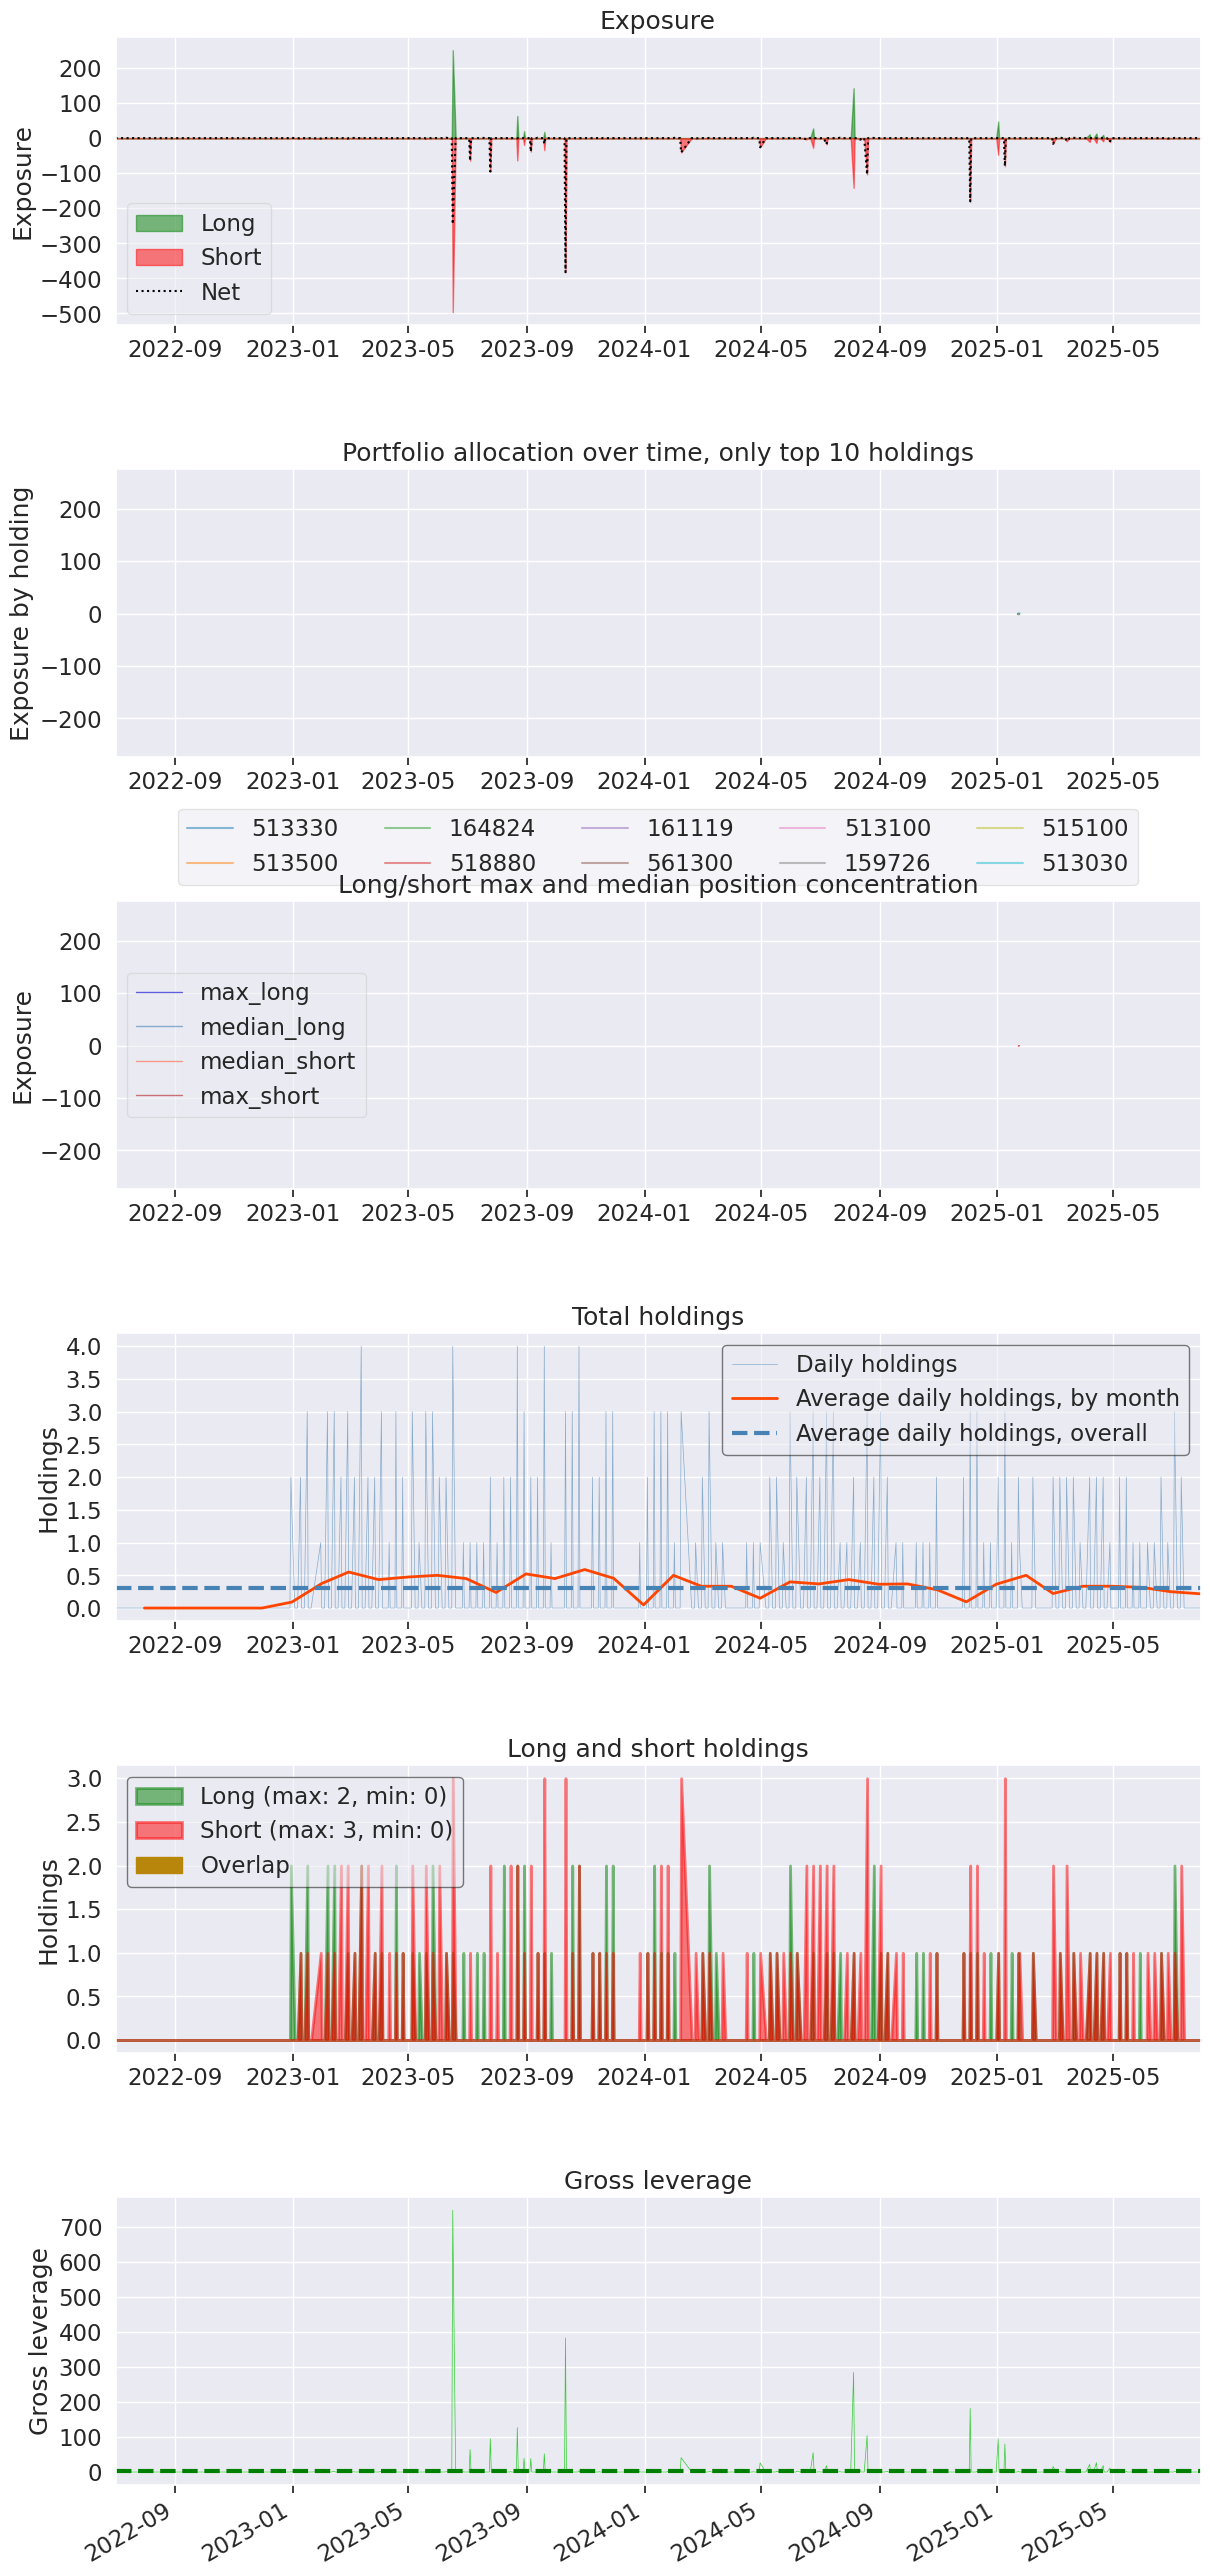

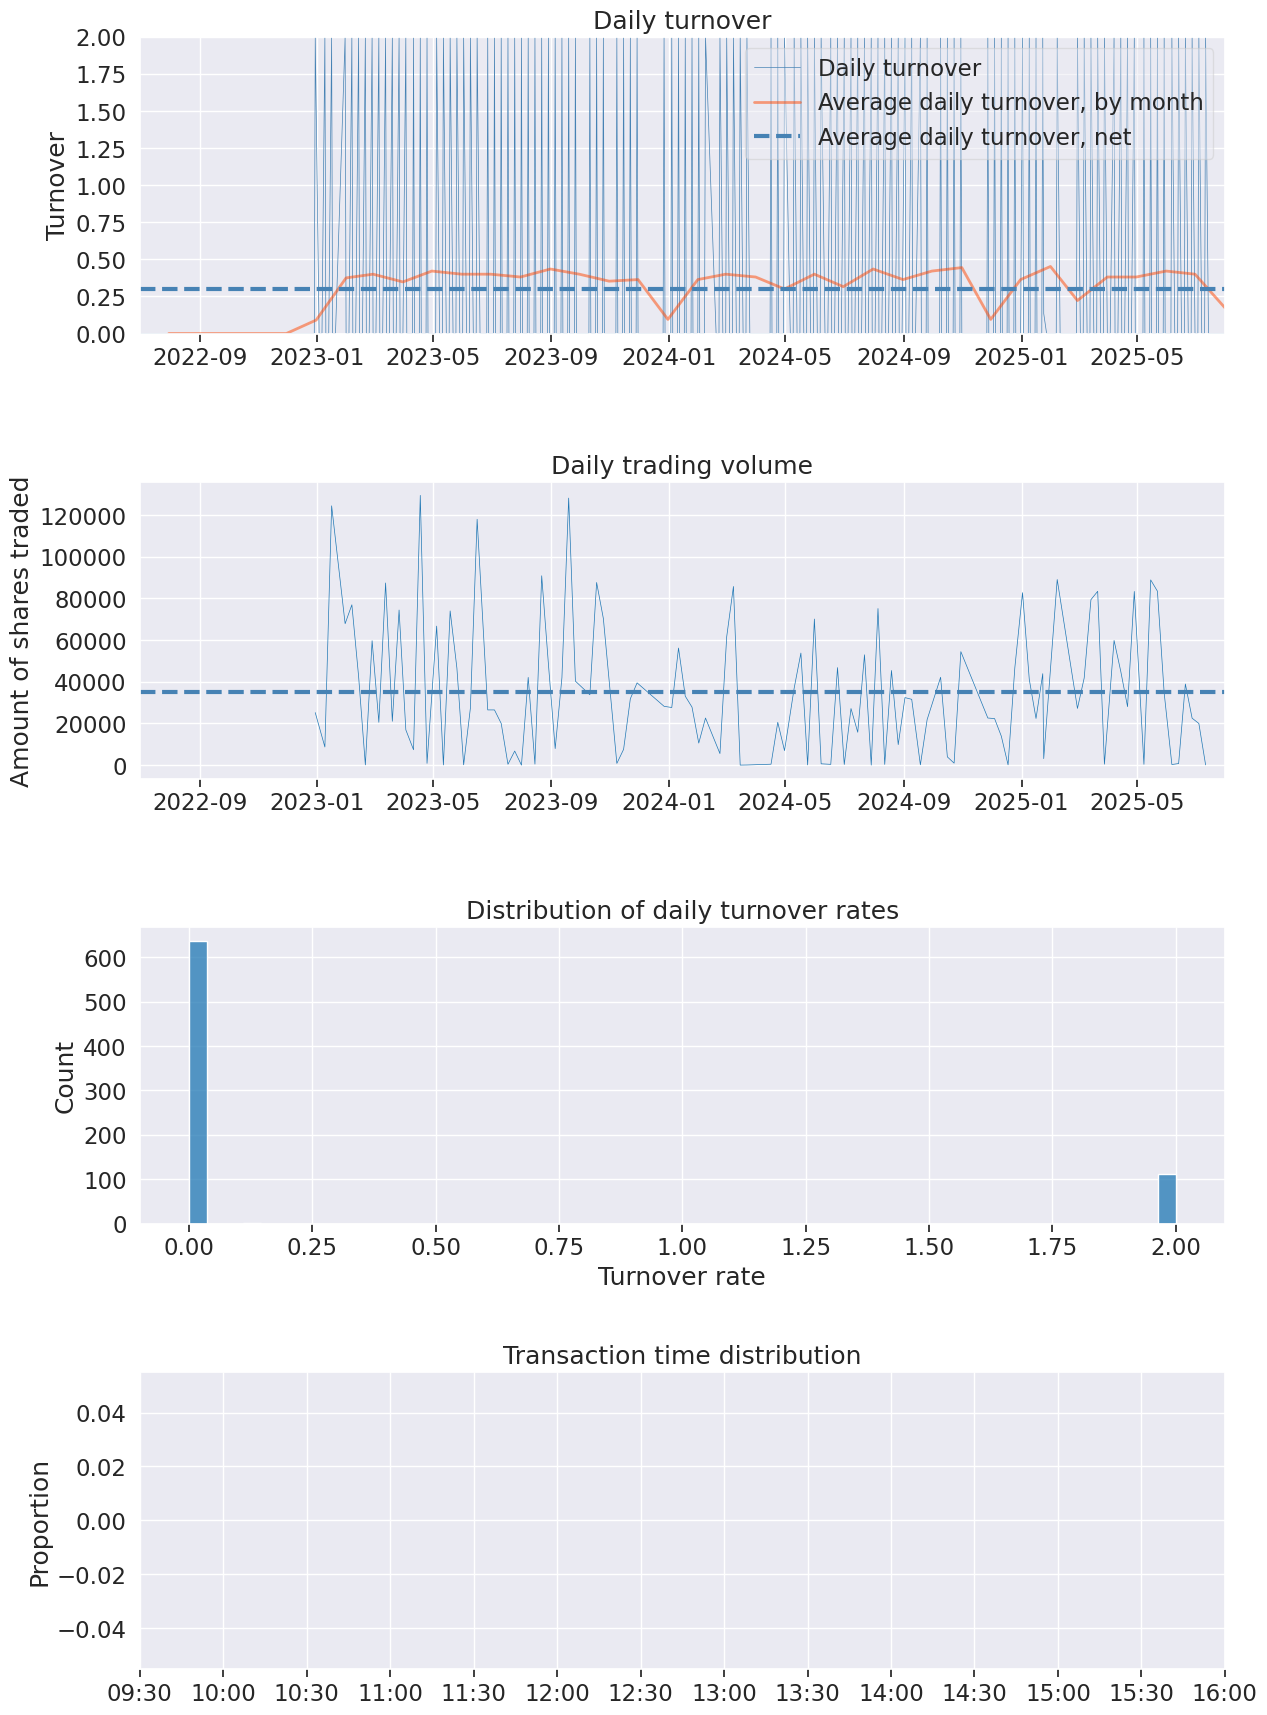

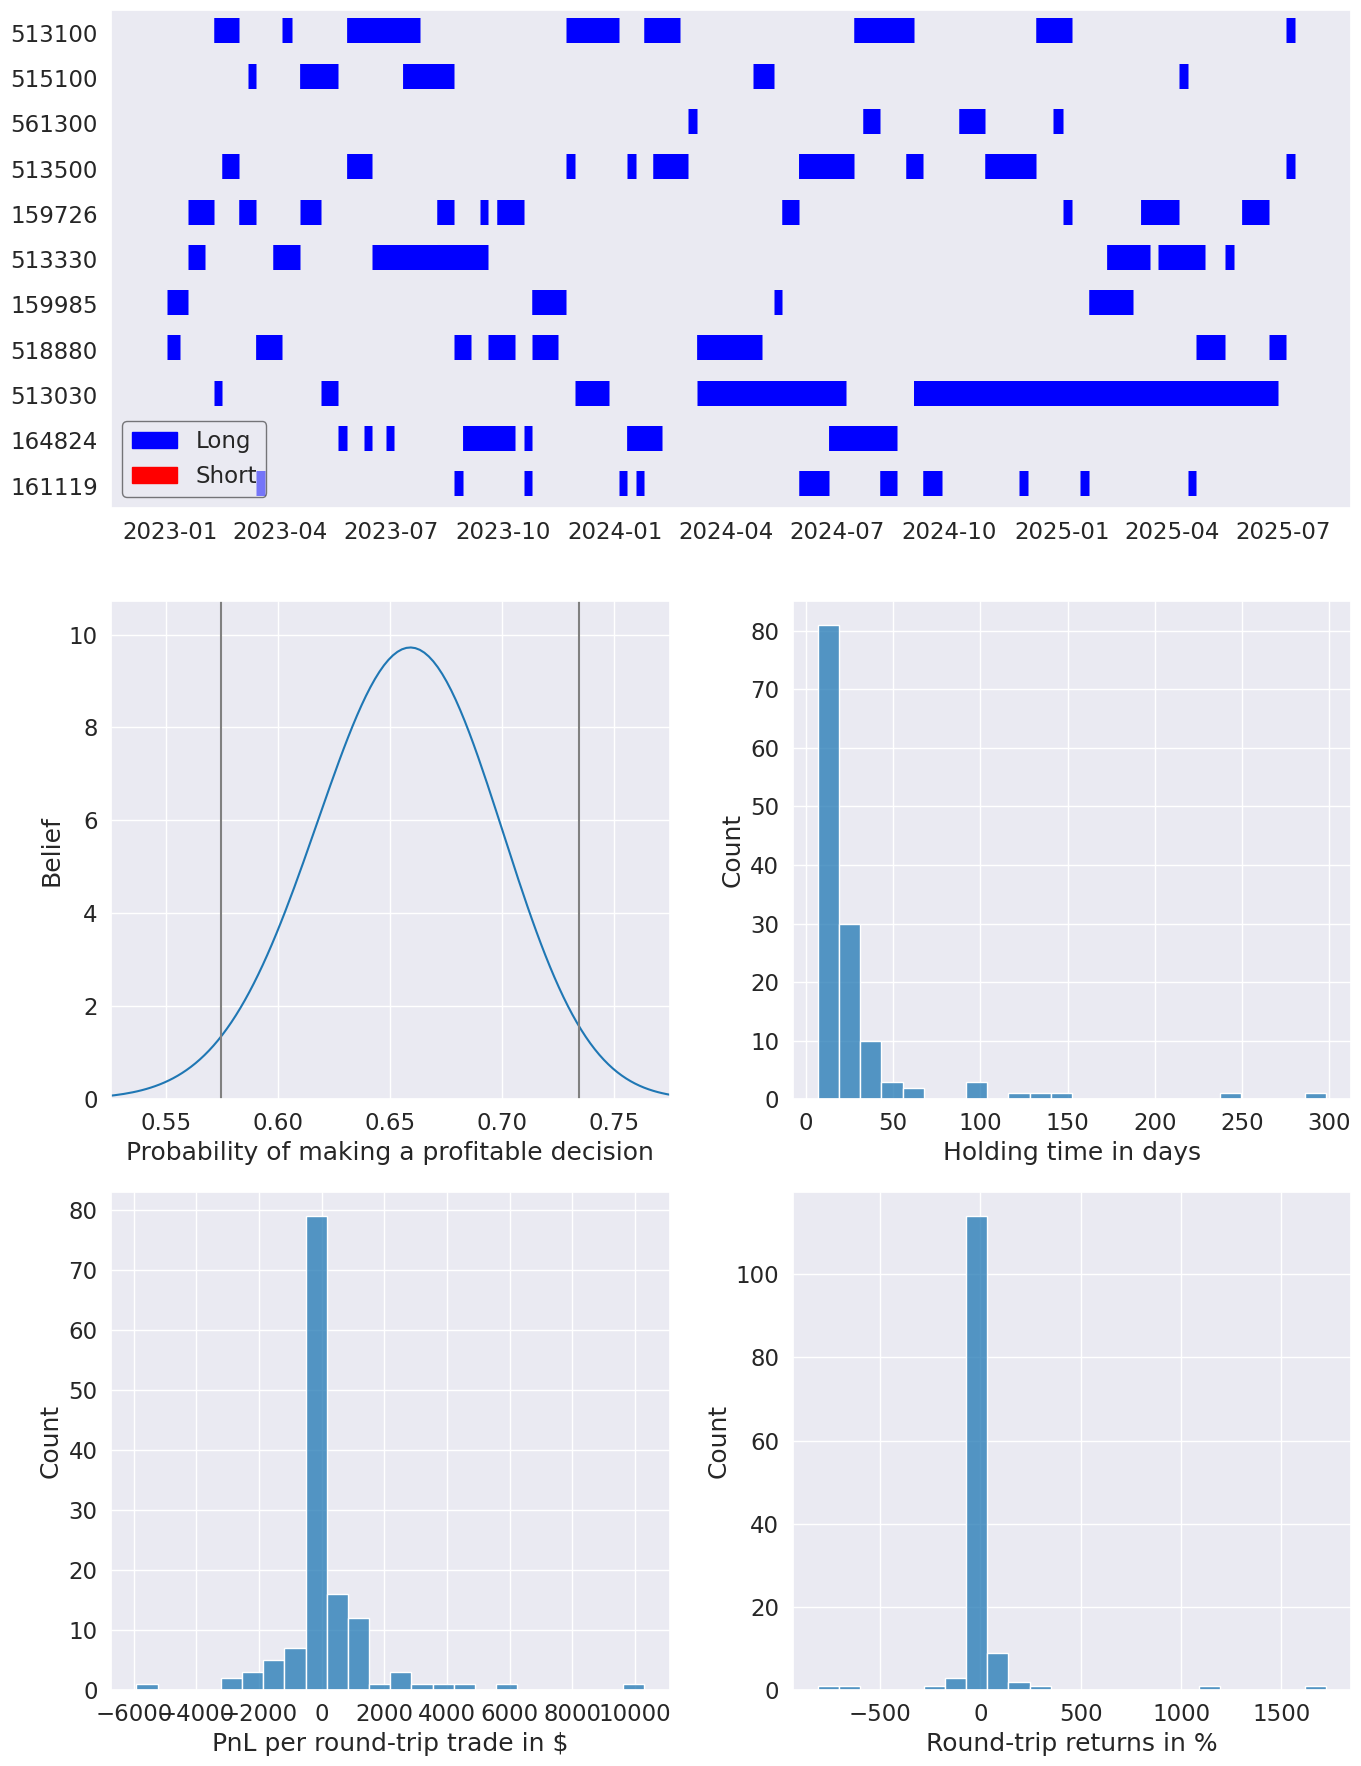

In [32]:
import pyfolio as pf

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    round_trips=True)

index
2022-07-01 00:00:00+00:00    0.000000
2022-07-04 00:00:00+00:00    0.000000
2022-07-05 00:00:00+00:00    0.000000
2022-07-06 00:00:00+00:00    0.000000
2022-07-07 00:00:00+00:00    0.000000
                               ...   
2025-07-25 00:00:00+00:00   -0.007816
2025-07-28 00:00:00+00:00    0.000753
2025-07-29 00:00:00+00:00   -0.000164
2025-07-30 00:00:00+00:00   -0.003233
2025-07-31 00:00:00+00:00   -0.004580
Name: return, Length: 749, dtype: float64

In [11]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2022-12-30 00:00:00+00:00,841,3.970,5,518880,-3338.770
2022-12-30 00:00:00+00:00,1678,1.987,7,159985,-3334.186
2023-01-09 00:00:00+00:00,3944,0.842,1,159726,-3320.848
2023-01-09 00:00:00+00:00,-9,4.016,5,518880,36.144
2023-01-09 00:00:00+00:00,-1678,1.955,7,159985,3280.490
...,...,...,...,...,...
2025-07-11 00:00:00+00:00,-1,4.248,3,513500,4.248
2025-07-11 00:00:00+00:00,501,8.170,9,513100,-4093.170
2025-07-18 00:00:00+00:00,-969,4.282,3,513500,4149.258
